In [1]:
import os
import sys
ROOT = os.getenv('BONNER_ROOT_PATH')
sys.path.append(ROOT)
from model_evaluation.results.predicting_brain_data.tools import plot_results
from model_features.models.expansion_3_layers import Expansion
from model_features.models.models import load_model_dict

# Main Results

### expansion model

In [2]:
dataset = 'naturalscenes'
hook = None

data_dict = {}
models = ['expansion_10','expansion_100','expansion_1000','expansion_10000']
for model in models:
    data_dict[model] = load_model_dict(model)
    
palette = {'expansion_model':'mediumseagreen'}

#### V1-V4

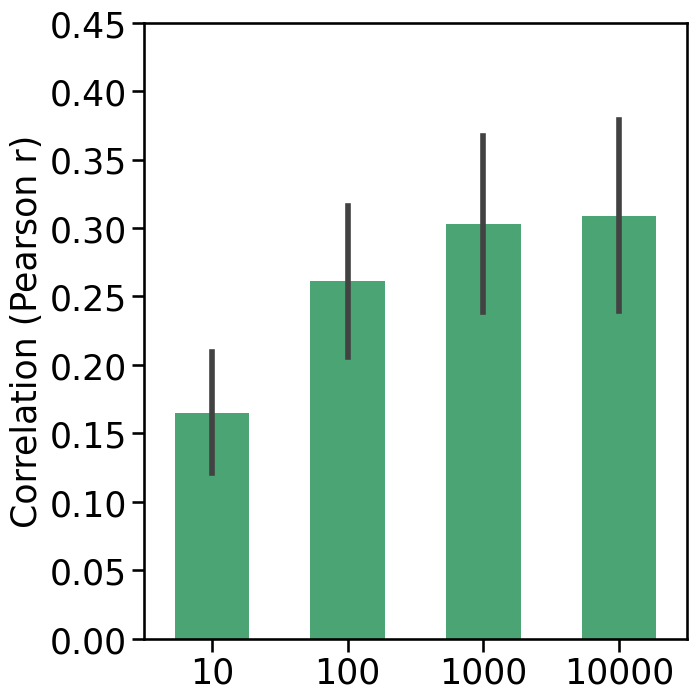

In [12]:
regions = ['V1','V2','V3','V4']

plot_results(data_dict = data_dict, plot_type = 'scores_vs_num_features', x_axis = 'num_features',
                 dataset = dataset, regions = regions, 
                 palette=palette,
                 ylim = (0,0.45), 
                 width = 0.55, 
                 show_legend= False, 
                 params = (7,8), 
                 name_dict= None, 
                 file_name=f'{dataset}_{regions}')

#### nsd general

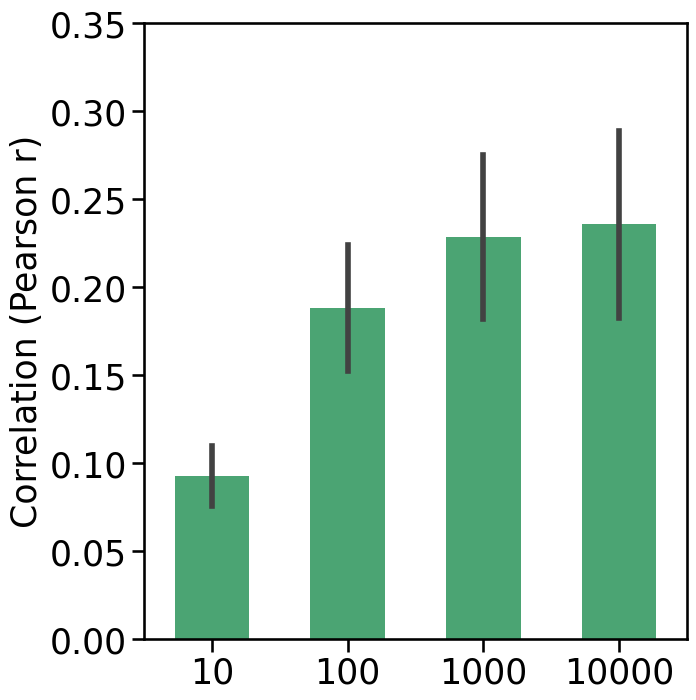

In [11]:
regions = ['general']

plot_results(data_dict = data_dict, plot_type = 'scores_vs_num_features', x_axis = 'num_features',
                 dataset = dataset, regions = regions, 
                 palette=palette,
                 ylim = (0,0.35), 
                 width = 0.55, 
                 show_legend= False, 
                 params = (7,8), 
                 name_dict= None, 
                 file_name=f'{dataset}_{regions}')

### alexnet

In [2]:
dataset = 'naturalscenes'
hook = None
mode = 'ridgecv'

#### v1-v4

In [3]:
data_dict = {}
models = ['alexnet_conv3','alexnet_untrained_conv4']
for model in models:
    data_dict[model] = load_model_dict(model)

palette = {'alexnet_conv3':'steelblue', 'alexnet_untrained_conv4':'darkgray'}
regions = ['V1','V2','V3','V4']

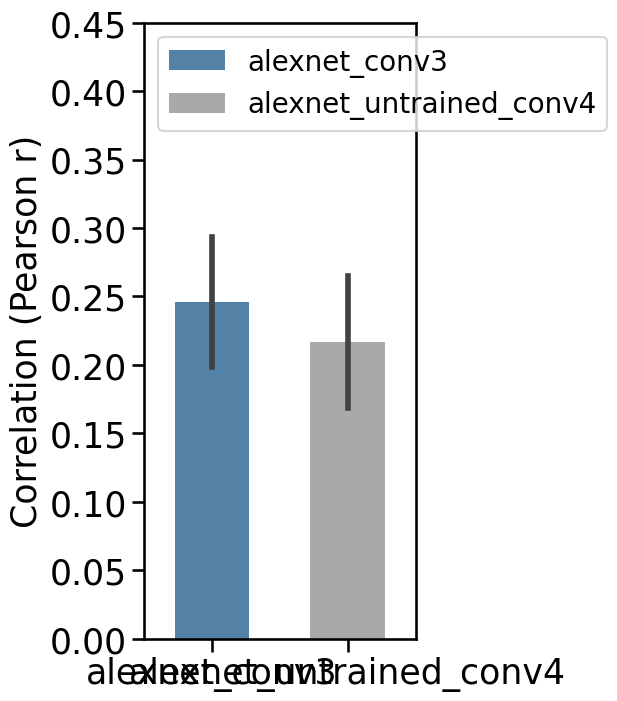

In [5]:
plot_results(data_dict = data_dict, plot_type = 'compare_models', 
                 dataset = dataset, regions = regions,
                 palette=palette,
                 ylim = (0,0.45), 
                 width = 0.55, 
                 show_legend= True, 
                 params = (3.5,8), 
                 file_name=f'{dataset}_{regions}_alexnet')

#### nsd general

In [6]:
data_dict = {}
models = ['alexnet_conv5', 'alexnet_untrained_conv5']
for model in models:
    data_dict[model] = load_model_dict(model)

name_dict  = {'alexnet_conv5':'AlexNet', 'alexnet_untrained_conv5':'AlexNet Untrained'}
palette = {'AlexNet':'steelblue','AlexNet Untrained':'darkgray'}
regions = ['general']

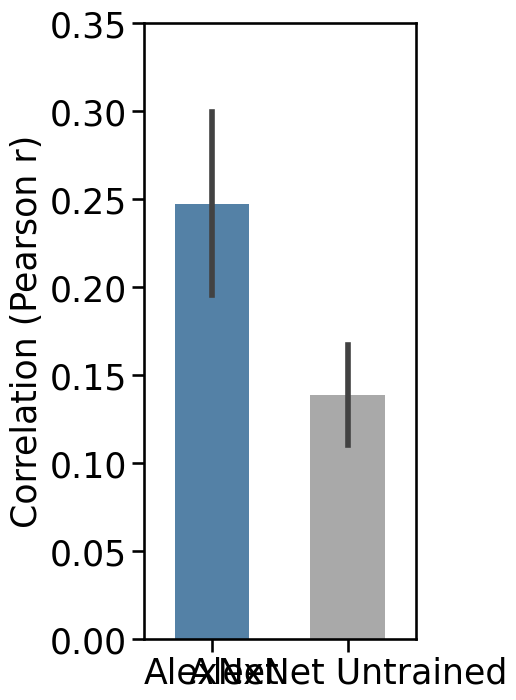

In [8]:
plot_results(data_dict = data_dict, plot_type = 'compare_models', 
                 dataset = dataset, regions = regions, 
                 palette=palette,
                 ylim = (0,0.35), 
                 width = 0.55, 
                 show_legend= False, 
                 params = (3.5,8), 
                 name_dict= name_dict, 
                 file_name=f'{dataset}_{regions}_alexnet')

# Additional Results: Majajhong Data

### expansion

In [20]:
dataset = 'majajhong'
mode = 'ridgecv'
hook = None

data_dict = {}
models = ['expansion_10','expansion_100','expansion_1000','expansion_10000']
for model in models:
    data_dict[model] = load_model_dict(model)
    
palette = {'expansion_model':'mediumseagreen'}

#### V4

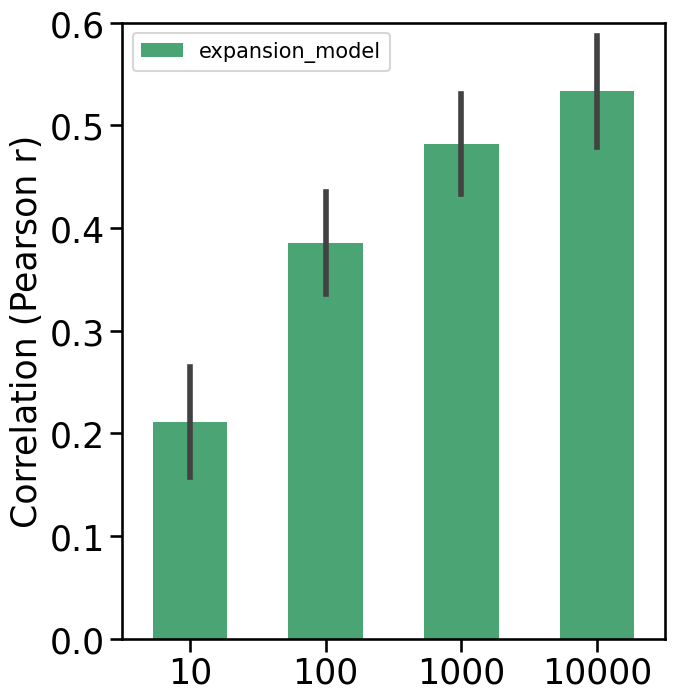

In [16]:
regions = ['V4']

plot_results(data_dict = data_dict, plot_type = 'scores_vs_num_features', x_axis = 'num_features',
                 dataset = dataset, regions = regions, mode = mode, hook = hook, 
                 palette=palette,
                 ylim = (0,0.6), 
                 width = 0.55, 
                 show_legend= True, 
                 params = (7,8), 
                 name_dict= None, 
                 file_name=f'{dataset}_{regions}')

#### IT

In [ ]:
regions = ['IT']

plot_results(data_dict = data_dict, plot_type = 'scores_vs_num_features', x_axis = 'num_features',
                 dataset = dataset, regions = regions, mode = mode,  
                 palette=palette,
                 ylim = (0,0.6), 
                 width = 0.55, 
                 show_legend= True, 
                 params = (7,8), 
                 name_dict= None, 
                 file_name=f'{dataset}_{regions}')

### alexnet

In [ ]:
dataset = 'majajhong'
hook = None
mode = 'ridgecv'

data_dict = {}
models = ['alexnet_conv5', 'alexnet_untrained_conv5']
for model in models:
    data_dict[model] = load_model_dict(model)
    
name_dict  = {'alexnet_conv5':'trained', 'alexnet_untrained_conv5':'untrained'}
palette = {'trained':'mediumslateblue','untrained':'gray'}

#### V4

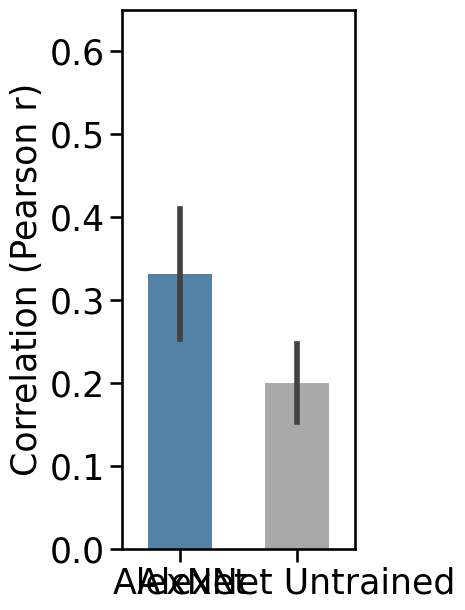

In [42]:
regions = ['V4']

plot_results(data_dict = data_dict, plot_type = 'compare_models', 
                 dataset = dataset, regions = regions, mode = mode,  hook = hook,
                 palette=palette,
                 ylim = (0,0.4), 
                 width = 0.65, 
                 show_legend= True, 
                 params = (7,8), 
                 name_dict= name_dict, 
                 file_name=f'{dataset}_{regions}')

#### IT

In [ ]:
regions = ['IT']

plot_results(data_dict = data_dict, plot_type = 'compare_models', 
                 dataset = dataset, regions = regions, mode = mode,  hook = hook,
                 palette=palette,
                 ylim = (0,0.4), 
                 width = 0.65, 
                 show_legend= True, 
                 params = (7,8), 
                 name_dict= name_dict, 
                 file_name=f'{dataset}_{regions}')

# Effect of wavelet filters

In [20]:
dataset = 'naturalscenes'
regions = ['general']
mode = 'ridgecv'

data_dict = {}
models = ['expansion_10000', 'fully_random']
for model in models:
    data_dict[model] = load_model_dict(model)
    
name_dict = {'expansion_model':'Wavelet','expansion_model_fully_random':'Random'}
palette = {'Wavelet':'mediumseagreen','Random':'palevioletred'}

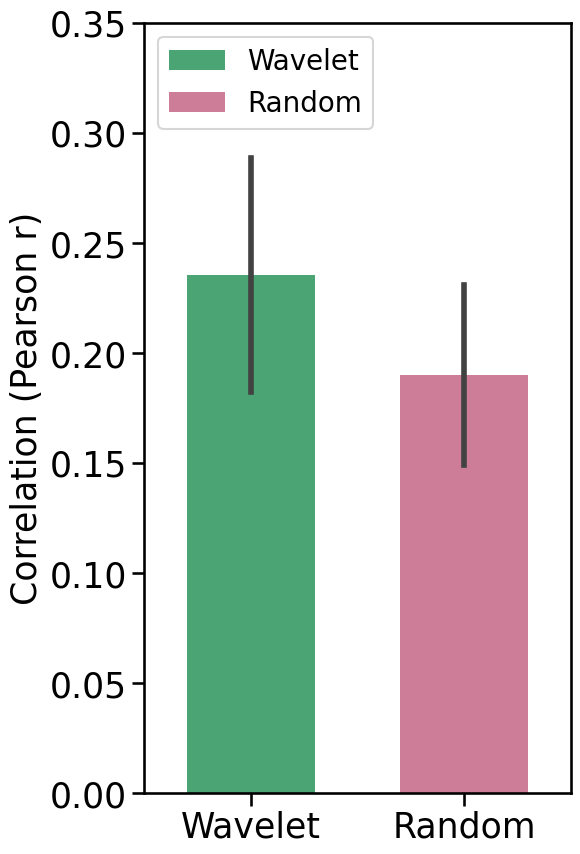

In [21]:
plot_results(data_dict = data_dict, plot_type = 'compare_models', 
                 dataset = dataset, regions = regions, 
                 palette=palette,
                 ylim = (0,0.35), 
                 width = 0.6, 
                 show_legend= True, 
                 params = (5,10), 
                 name_dict= name_dict, 
                 file_name=f'effect_of_wavelet_filters')

# Effect of Architecture

In [2]:
dataset = 'naturalscenes'
regions = ['general']
mode = 'ridgecv'

data_dict = {}
models = ['fully_connected_10', 'fully_connected_100', 'fully_connected_1000', 'fully_connected_10000', 
          'fully_connected_3_layers_10', 'fully_connected_3_layers_100', 'fully_connected_3_layers_1000', 'fully_connected_3_layers_10000',
          'expansion_10', 'expansion_100', 'expansion_1000', 'expansion_10000']
for model in models:
    data_dict[model] = load_model_dict(model)
    
name_dict = {'fully_connected':'Fully Connected', 'fully_connected_3_layers':'Fully Connected 3 Layers','expansion_model':'Expansion Model'}
palette = {'Expansion Model':'mediumseagreen','Fully Connected':'plum', 'Fully Connected 3 Layers':'mediumslateblue'}

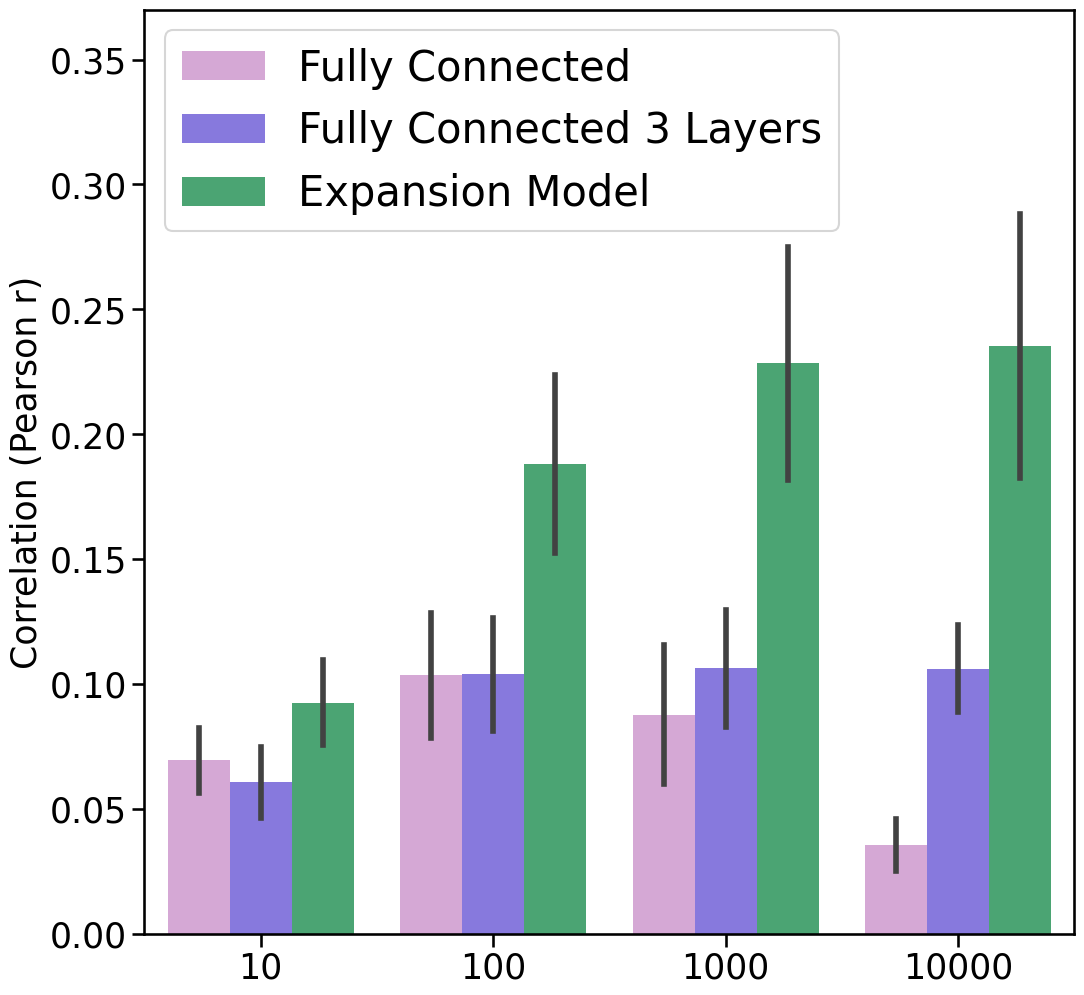

In [12]:
plot_results(data_dict = data_dict, plot_type = 'scores_vs_num_features', x_axis='num_features',
                 dataset = dataset, regions = regions, 
                 palette=palette,
                 ylim = (0,0.37), 
                 width = 0.8, 
                 show_legend= True, 
                 params = (12, 12), 
                 name_dict= name_dict, 
                 file_name=f'effect_of_architecture')

# Effect of high dim regression

In [9]:
dataset = 'naturalscenes'
regions = ['general']
mode = 'ridgecv'

#### expansion vs linear model

In [20]:
data_dict = {}
models = ['expansion_10000', 'expansion_linear']
for model in models:
    data_dict[model] = load_model_dict(model)
    
name_dict = {'expansion_model':'Expansion Model','expansion_model_linear':'Linear Model'}
palette = {'Expansion Model':'mediumseagreen','Linear Model':'rosybrown'}

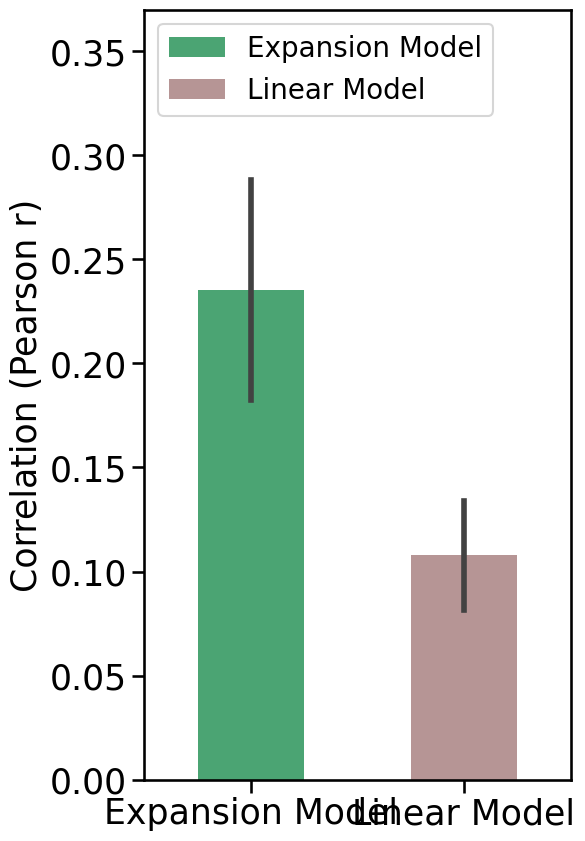

In [21]:
plot_results(data_dict = data_dict, plot_type = 'compare_models', 
                 dataset = dataset, regions = regions, 
                 palette=palette,
                 ylim = (0,0.37), 
                 width = 0.5, 
                 show_legend= True, 
                 params = (5.5,10), 
                 name_dict= name_dict, 
                 file_name=f'expansion_vs_linear')

#### expansion model PCs vs alexnet

In [10]:
data_dict = {}
models = ['expansion_first_256_pcs','alexnet_conv5']
for model in models:
    data_dict[model] = load_model_dict(model)
    
name_dict = {'expansion_model_first_256_pcs':'Expansion Model PCs','alexnet_conv5':'Alexnet'}
palette = {'Expansion Model PCs':'mediumseagreen','Alexnet':'steelblue'}

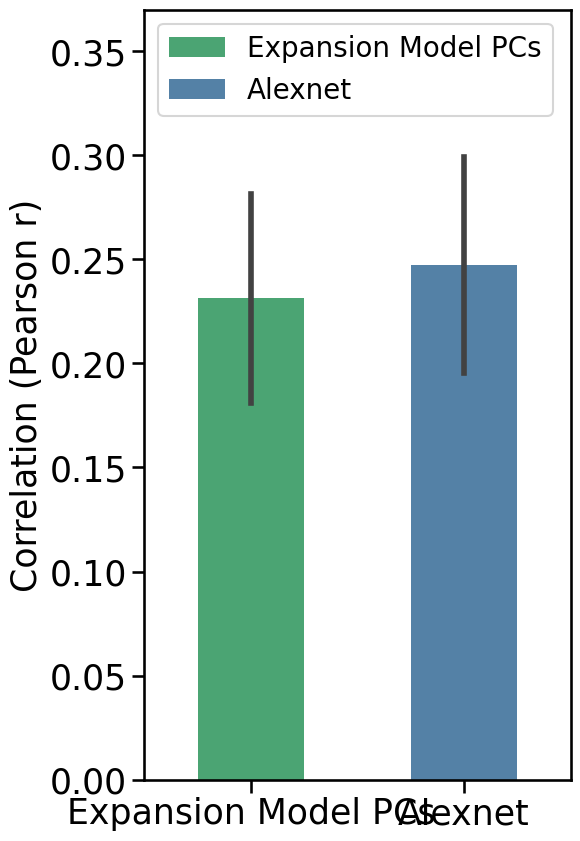

In [12]:
plot_results(data_dict = data_dict, plot_type = 'compare_models', 
                 dataset = dataset, regions = regions,
                 palette=palette,
                 ylim = (0,0.37), 
                 width = 0.5, 
                 show_legend= True, 
                 params = (5.5,10), 
                 name_dict= name_dict, 
                 file_name=f'expansion_pcs_vs_alexnet')